# 中小微企业信贷决策分析

**重要提示：** 
- 如果图表中文显示为方框，请 **重启内核（Restart Kernel）** 后重新运行所有单元格
- 字体配置需要在导入matplotlib之前完成

In [1]:
# ===========================================================
# 模块一：环境配置与数据加载
# ===========================================================
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings

# --- 环境设置 ---
warnings.filterwarnings('ignore')

# 手动添加中文字体
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()

# 配置matplotlib使用中文字体
matplotlib.rcParams['font.sans-serif'] = [font_name, 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.size'] = 10

# 验证字体配置
print("="*60)
print("环境配置检查")
print("="*60)
print(f"matplotlib版本: {matplotlib.__version__}")
print(f"pandas版本: {pd.__version__}")
print(f"中文字体: {font_name}")
print(f"字体配置: {matplotlib.rcParams['font.sans-serif'][:2]}")
print("="*60)

环境配置检查
matplotlib版本: 3.10.7
pandas版本: 2.3.3
中文字体: Noto Sans CJK JP
字体配置: ['Noto Sans CJK JP', 'DejaVu Sans']


In [2]:
# --- 数据加载 ---
print("\n--- 模块一：正在加载数据 ---")
try:
    # SQL类比: 像是 'USE DATABASE "附件1.xlsx";'
    data_path = '2020C-中小微企业信贷决策/数据/附件1：123家有信贷记录企业的相关数据.xlsx'
    xls = pd.ExcelFile(data_path)

    # SQL类比: 'SELECT * FROM "企业信息";'
    df_qiyexinxi = pd.read_excel(xls, '企业信息')
    
    # SQL类比: 'SELECT * FROM "进项发票信息";'
    df_jinxiang = pd.read_excel(xls, '进项发票信息')
    
    # SQL类比: 'SELECT * FROM "销项发票信息";'
    df_xiaoxiang = pd.read_excel(xls, '销项发票信息')
    
    print("✅ 数据加载成功！")
    print(f"  企业信息 (维度表): {df_qiyexinxi.shape}")
    print(f"  进项发票 (事实表): {df_jinxiang.shape}")
    print(f"  销项发票 (事实表): {df_xiaoxiang.shape}")

except FileNotFoundError:
    print(f"❌ 错误：未在当前目录找到文件 '{data_path}'")
    print("请检查文件路径是否正确。")


--- 模块一：正在加载数据 ---
✅ 数据加载成功！
  企业信息 (维度表): (123, 4)
  进项发票 (事实表): (210947, 8)
  销项发票 (事实表): (162484, 8)
✅ 数据加载成功！
  企业信息 (维度表): (123, 4)
  进项发票 (事实表): (210947, 8)
  销项发票 (事实表): (162484, 8)


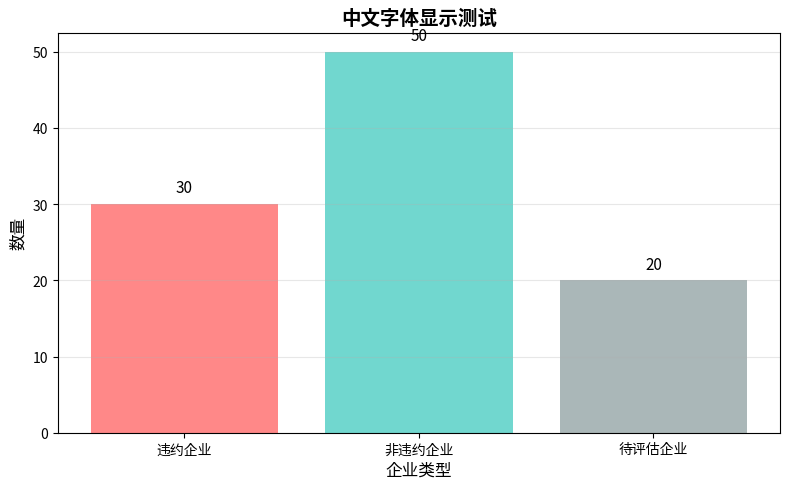


✅ 如果上图中文正常显示，字体配置成功！
✅ 现在可以继续运行后续的分析单元格


In [8]:
# 测试中文显示
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
test_data = [30, 50, 20]
test_labels = ['违约企业', '非违约企业', '待评估企业']
colors = ['#ff6b6b', '#4ecdc4', '#95a5a6']

ax.bar(test_labels, test_data, color=colors, alpha=0.8)
ax.set_title('中文字体显示测试', fontsize=14, fontweight='bold')
ax.set_xlabel('企业类型', fontsize=12)
ax.set_ylabel('数量', fontsize=12)
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(test_data):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ 如果上图中文正常显示，字体配置成功！")
print("✅ 现在可以继续运行后续的分析单元格")

In [9]:
print(df_qiyexinxi)
print(df_jinxiang)
print(df_xiaoxiang)


     企业代号                 企业名称 信誉评级 是否违约
0      E1          ***电器销售有限公司    A    否
1      E2          ***技术有限责任公司    A    否
2      E3  ***电子(中国)有限公司***分公司    C    否
3      E4          ***发展有限责任公司    C    否
4      E5         ***供应链管理有限公司    B    否
..    ...                  ...  ...  ...
118  E119                ***药房    D    是
119  E120          ***陈列广告有限公司    D    是
120  E121     ***药业连锁有限公司***药店    D    是
121  E122          ***商贸有限责任公司    D    是
122  E123         ***创科技有限责任公司    D    是

[123 rows x 4 columns]
        企业代号      发票号码       开票日期  销方单位代号       金额      税额     价税合计  发票状态
0         E1   3390939 2017-07-18  A00297  -943.40  -56.60 -1000.00  有效发票
1         E1   3390940 2017-07-18  A00297 -4780.24 -286.81 -5067.05  有效发票
2         E1   3390941 2017-07-18  A00297   943.40   56.60  1000.00  有效发票
3         E1   3390942 2017-07-18  A00297  4780.24  286.81  5067.05  有效发票
4         E1   9902669 2017-08-07  A05061   326.21    9.79   336.00  有效发票
...      ...       ...        ...     ..

In [4]:
# ===========================================================
# 模块二：数据清洗与整合（业务逻辑修正版）
# ===========================================================
print("\n--- 模块二：正在清洗与整合数据 (业务逻辑修正) ---")

# --- 步骤 1: 在各自的表中明确标记发票类型（进项/销项） ---
# 这是最关键的第一步，在合并之前就打好标签，避免混淆。
# SQL类比: 
# ALTER TABLE "进项发票信息" ADD COLUMN "发票流向" VARCHAR(10) DEFAULT '进项';
# ALTER TABLE "销项发票信息" ADD COLUMN "发票流向" VARCHAR(10) DEFAULT '销项';

df_jinxiang['发票流向'] = '进项'  # 进项发票，代表资金流出
df_xiaoxiang['发票流向'] = '销项' # 销项发票，代表资金流入

print("  步骤1: 已在原始发票表中明确标记 '发票流向'。")


# --- 步骤 2: 统一交易对手的列名 ---
# 现在我们清晰地知道，这两个不同的列，都代表“交易对手”。
# SQL类比:
# ALTER TABLE "进项发票信息" RENAME COLUMN "销方单位代号" TO "交易对手代号";
# ALTER TABLE "销项发票信息" RENAME COLUMN "购方单位代号" TO "交易对手代号";

df_jinxiang.rename(columns={'销方单位代号': '交易对手代号'}, inplace=True)
df_xiaoxiang.rename(columns={'购方单位代号': '交易对手代号'}, inplace=True)

print("  步骤2: 已将 '销方单位代号' 和 '购方单位代号' 统一为 '交易对手代号'。")


# --- 步骤 3: 合并 (UNION ALL) ---
# 因为列名和类型都已对齐，现在可以安全地进行合并。
df_combined = pd.concat([df_jinxiang, df_xiaoxiang], ignore_index=True)
print(f"  步骤3: 已将进项销项表 UNION ALL 合并。合并后总行数: {len(df_combined)}")


# --- 步骤 4: 关联目标变量与核心清洗 ---
# SQL类比: LEFT JOIN + UPDATE/CAST/TRIM

# a) 关联 '是否违约' 标签 (这是模块四聚合的前提)
df_combined = pd.merge(df_combined, df_qiyexinxi[['企业代号', '是否违约']], on='企业代号', how='left')

# b) 清洗 '是否违约' (文本转0/1)
df_combined['是否违约'] = df_combined['是否违约'].astype(str).str.strip().map({'是': 1, '否': 0})

# c) 清洗 '发票状态' (去除空格)
df_combined['发票状态'] = df_combined['发票状态'].str.strip()

# d) 转换日期格式
df_combined['开票日期'] = pd.to_datetime(df_combined['开票日期'], errors='coerce')

# e) 转换数值格式
for col in ['金额', '税额', '价税合计']:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

print("  步骤4: 已关联目标变量并完成核心字段的清洗和格式转换。")


# --- 步骤 5: 处理缺失值 ---
initial_rows = len(df_combined)
# 核心字段缺失的数据行没有分析价值
df_combined.dropna(subset=['是否违约', '开票日期', '金额', '交易对手代号'], inplace=True)
if initial_rows > len(df_combined):
    print(f"  步骤5: 已删除 {initial_rows - len(df_combined)} 行存在核心字段缺失的数据。")

# 把df_combined保存为新的Excel文件，供后续分析使用
output_path = '2020C-中小微企业信贷决策/数据/cleaned_invoice_data.xlsx'
df_combined.to_excel(output_path, index=False)
print(f"已将清洗后的发票流水表保存为 '{output_path}'")

print(f"\n✅ 模块二完成！清洗后的发票流水表形状: {df_combined.shape}")
print(f"  最终字段列表: {df_combined.columns.tolist()}")


--- 模块二：正在清洗与整合数据 (业务逻辑修正) ---
  步骤1: 已在原始发票表中明确标记 '发票流向'。
  步骤2: 已将 '销方单位代号' 和 '购方单位代号' 统一为 '交易对手代号'。
  步骤3: 已将进项销项表 UNION ALL 合并。合并后总行数: 373431
  步骤4: 已关联目标变量并完成核心字段的清洗和格式转换。
  步骤4: 已关联目标变量并完成核心字段的清洗和格式转换。
已将清洗后的发票流水表保存为 '2020C-中小微企业信贷决策/数据/cleaned_invoice_data.xlsx'

✅ 模块二完成！清洗后的发票流水表形状: (373431, 10)
  最终字段列表: ['企业代号', '发票号码', '开票日期', '交易对手代号', '金额', '税额', '价税合计', '发票状态', '发票流向', '是否违约']
已将清洗后的发票流水表保存为 '2020C-中小微企业信贷决策/数据/cleaned_invoice_data.xlsx'

✅ 模块二完成！清洗后的发票流水表形状: (373431, 10)
  最终字段列表: ['企业代号', '发票号码', '开票日期', '交易对手代号', '金额', '税额', '价税合计', '发票状态', '发票流向', '是否违约']


下面是模块三的**大纲**，你必须按照这个结构，逐一进行分析和可视化。用你的代码去**验证或推翻**这些潜在的风险信号。

---

### **模块三：探索性数据分析 (EDA) 大纲**

**核心数据:**
* `df_combined`: 模块二产出的、干净的发票流水表 (包含`是否违约`标签)
* `df_qiyexinxi`: 模块一加载的、干净的企业信息表

**分析主线:** 始终围绕**对比“违约组 (是否违约=1)”与“非违约组 (是否违约=0)”** 的差异展开。

---

**3.1. 整体概览与目标变量分布**

* **目标:** 再次确认基础信息，特别是企业层面的违约率。
* **动作:**
    * `df_qiyexinxi` 的 `describe()` 和 `info()`: 查看企业信息表的基本情况。
    * `df_combined` 的 `describe()` 和 `info()`: 查看发票流水表的基本情况。
    * **计算并可视化企业层面的违约率**: 必须基于 `df_qiyexinxi` 计算 (预期约为 22%)。
    * *(SQL类比: `SELECT COUNT(*), 是否违约 FROM df_qiyexinxi GROUP BY 是否违约;`)*

---

**3.2. 企业静态属性分析 (基于 `df_qiyexinxi`)**

* **目标:** 分析企业固有属性与违约的关系。
* **动作:**
    * **`信誉评级` vs. `是否违约`**:
        * **计算**：不同信誉评级 (`A`, `B`, `C`, `D`) 下的**违约率**。
        * **可视化**: 用**百分比堆积条形图** 或 **分组条形图** 展示不同评级下的违约比例。
        * **提出假设**: 例如，“假设：信誉评级是预测违约的重要静态特征。”
        * *(SQL类比: `SELECT 信誉评级, AVG(CASE WHEN 是否违约=1 THEN 1 ELSE 0 END) FROM df_qiyexinxi GROUP BY 信誉评级;`)*

---

**3.3. 发票层面的交易行为分析 (基于 `df_combined`)**

* **目标:** 从单张发票的特征中，寻找违约与非违约行为模式的差异。
* **动作:**
    * **`发票状态` vs. `是否违约`**:
        * **计算**: 违约组和非违约组中，`作废发票` 的**比例**。
        * **可视化**: 百分比堆积条形图。
        * **（选做）统计检验**: 进行**卡方检验**，量化相关性是否显著。
        * **提出假设**: 例如，“假设：作废发票比例高的企业，违约风险更高。”
    * **`发票流向` vs. `是否违约`**:
        * **计算**: 违约组和非违约组中，`进项` 和 `销项` 发票的**数量比例**和**金额比例**。
        * **可视化**: 分组条形图或饼图。
        * **提出假设**: 例如，“假设：违约企业可能在销项（销售）活动上表现更差。”
    * **交易金额 (`金额`, `价税合计`) vs. `是否违约`**:
        * **计算**: 违约组和非违约组的 `金额`（或`价税合计`）的**绝对值**的**均值、中位数、标准差**。
        * **可视化**: 使用**箱形图 (Box Plot)** 或 **小提琴图 (Violin Plot)** 对比两组金额绝对值的分布。**注意：** 数据可能高度倾斜，需要考虑**去除极端异常值**（例如只画 1% 到 99% 分位数之间的数据）或使用**对数变换 (Log Transform)** 来改善可视化效果。
        * **（选做）统计检验**: 进行**T检验**，判断两组均值差异是否显著。
        * **提出假设**: 例如，“假设：违约企业的平均交易额显著低于非违约企业。” 或 “假设：违约企业的交易额波动性更大。”
    * **红字发票 (`金额` < 0) vs. `是否违约`**:
        * **计算**: 违约组和非违约组中，红字发票的**数量比例**。
        * **计算**: 违约组和非违约组中，红字发票**金额绝对值的均值/中位数**。
        * **可视化**: 百分比堆积条形图（比例）和箱形图（金额）。
        * **提出假设**: 例如，“假设：红字发票比例或金额异常是违约的危险信号。”

---

**3.4. 时间维度分析 (基于 `df_combined`)**

* **目标:** 观察企业经营活动随时间的变化趋势，寻找潜在的恶化信号。
* **动作:**
    * **总体趋势**:
        * **计算**: 按**月份**聚合所有企业的**发票总数**和**价税合计总额**（绝对值）。
        * **可视化**: 绘制**时间序列折线图**。观察是否存在明显的季节性、增长/下降趋势或异常点。
        * *(SQL类比: `SELECT DATE_TRUNC('month', 开票日期), COUNT(*), SUM(ABS(价税合计)) FROM df_combined GROUP BY 1 ORDER BY 1;`)*
    * **分组趋势**:
        * **计算**: 按**月份**和**`是否违约`** 分组聚合发票总数和总额。
        * **可视化**: 在**同一张图**上绘制违约组和非违约组的月度趋势线。对比两组趋势是否有分化？违约组是否在后期出现明显下滑？
        * **提出假设**: 例如，“假设：违约企业在违约前的一段时间内，月度交易额/发票数量呈现下降趋势。”

---

**3.5. 交易网络初步分析 (基于 `df_combined`)**

* **目标:** 初步探索企业商业网络的复杂度与其风险的关系。
* **动作:**
    * **交易对手数量**:
        * **计算**: 对每个`企业代号`，计算其**唯一 `交易对手代号` 的数量 (`nunique`)**。
        * **合并**: 将计算结果 `merge` 回 `df_qiyexinxi`（或一个包含企业唯一`是否违约`标签的临时表）。
        * **对比**: 比较违约组和非违约组的**交易对手数量**的分布（箱形图）。
        * **提出假设**: 例如，“假设：交易对手数量过少的企业，其经营风险更高。”
        * *(SQL类比: 先 `SELECT 企业代号, COUNT(DISTINCT 交易对手代号) FROM df_combined GROUP BY 企业代号;` 得到临时表，再 JOIN 回企业表进行分析)*

---

**输出要求:**

* 每一项分析都要有**清晰的标题**和**简短的文字结论**。
* 所有**可视化图表**必须包含**标题、坐标轴标签**，并且**易于理解**。
* 最终，在模块三的末尾，**汇总**你在这个阶段发现的所有**关键洞察**和**待验证的假设**列表，这将是你模块四特征工程的**直接输入**。

现在，去执行。用代码和图表，把数据的“故事”讲清楚。


模块三：探索性数据分析 (EDA)

--- 3.1. 整体概览与目标变量分布 ---

【企业信息表概览】
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   企业代号    123 non-null    object
 1   企业名称    123 non-null    object
 2   信誉评级    123 non-null    object
 3   是否违约    123 non-null    object
dtypes: object(4)
memory usage: 4.0+ KB
None

企业信息表统计描述:
       企业代号         企业名称 信誉评级 是否违约
count   123          123  123  123
unique  123           93    4    2
top      E1  ***建筑劳务有限公司    B    否
freq      1            7   38   96

【发票流水表概览】
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373431 entries, 0 to 373430
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   企业代号      373431 non-null  object        
 1   发票号码      373431 non-null  int64         
 2   开票日期      373431 non-null  datetime64[ns]
 3   交易对手代号    373431 non-null  obj

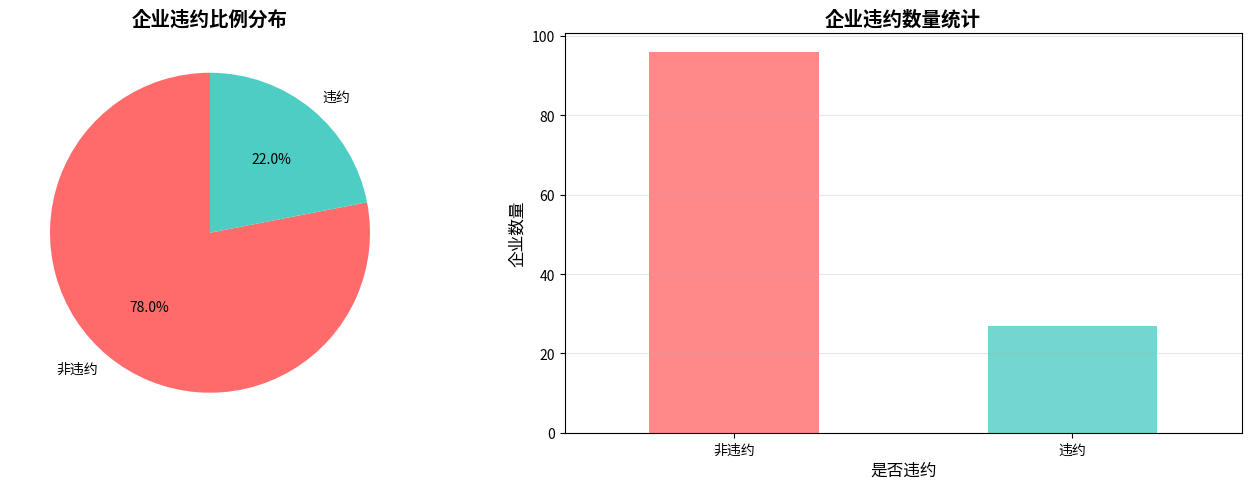


✅ 3.1 完成：违约率约为 21.95%


In [12]:
# ===========================================================
# 模块三：探索性数据分析 (EDA)
# ===========================================================
print("\n" + "="*60)
print("模块三：探索性数据分析 (EDA)")
print("="*60)

# ===========================================================
# 3.1. 整体概览与目标变量分布
# ===========================================================
print("\n--- 3.1. 整体概览与目标变量分布 ---")

# 查看企业信息表的基本情况
print("\n【企业信息表概览】")
print(df_qiyexinxi.info())
print("\n企业信息表统计描述:")
print(df_qiyexinxi.describe(include='all'))

# 查看发票流水表的基本情况
print("\n【发票流水表概览】")
print(df_combined.info())
print("\n发票流水表统计描述:")
print(df_combined.describe())

# 计算企业层面的违约率
print("\n【企业层面违约情况】")
default_counts = df_qiyexinxi['是否违约'].value_counts()
default_rate = df_qiyexinxi['是否违约'].value_counts(normalize=True) * 100

print(f"违约企业数: {default_counts.get('是', 0)}")
print(f"非违约企业数: {default_counts.get('否', 0)}")
print(f"违约率: {default_rate.get('是', 0):.2f}%")

# 可视化违约率
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 饼图
colors = ['#ff6b6b', '#4ecdc4']
axes[0].pie(default_counts, labels=['非违约', '违约'], autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('企业违约比例分布', fontsize=14, fontweight='bold')

# 柱状图
default_counts.plot(kind='bar', ax=axes[1], color=colors, alpha=0.8)
axes[1].set_title('企业违约数量统计', fontsize=14, fontweight='bold')
axes[1].set_xlabel('是否违约', fontsize=12)
axes[1].set_ylabel('企业数量', fontsize=12)
axes[1].set_xticklabels(['非违约', '违约'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ 3.1 完成：违约率约为 {:.2f}%".format(default_rate.get('是', 0)))


--- 3.2. 企业静态属性分析 ---

【不同信誉评级的违约率】
  A 级: 0.00% (共27家企业)
  B 级: 2.63% (共38家企业)
  C 级: 5.88% (共34家企业)
  D 级: 100.00% (共24家企业)


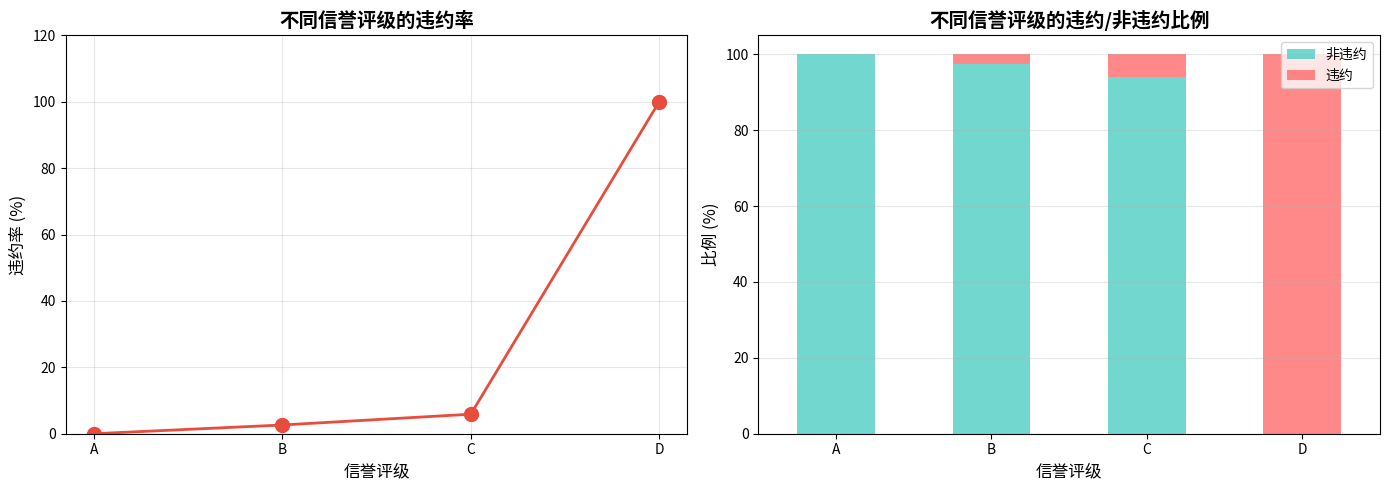


📊 假设验证: 信誉评级越低(D<C<B<A)，违约率越高 ✓


In [13]:

# ===========================================================
# 3.2. 企业静态属性分析
# ===========================================================
print("\n--- 3.2. 企业静态属性分析 ---")

# 清洗信誉评级数据
df_qiyexinxi['信誉评级'] = df_qiyexinxi['信誉评级'].astype(str).str.strip().str.upper()

# 计算不同信誉评级下的违约率
# SQL: SELECT 信誉评级, AVG(CASE WHEN 是否违约='是' THEN 1 ELSE 0 END) 
#      FROM df_qiyexinxi GROUP BY 信誉评级
rating_default = df_qiyexinxi.groupby('信誉评级')['是否违约'].apply(
    lambda x: (x == '是').sum() / len(x) * 100
).sort_index()

print("\n【不同信誉评级的违约率】")
for rating, rate in rating_default.items():
    count = df_qiyexinxi[df_qiyexinxi['信誉评级'] == rating].shape[0]
    print(f"  {rating} 级: {rate:.2f}% (共{count}家企业)")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 违约率折线图
axes[0].plot(rating_default.index, rating_default.values, marker='o', 
             linewidth=2, markersize=10, color='#e74c3c')
axes[0].set_title('不同信誉评级的违约率', fontsize=14, fontweight='bold')
axes[0].set_xlabel('信誉评级', fontsize=12)
axes[0].set_ylabel('违约率 (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, max(rating_default.values) * 1.2)

# 堆积条形图
rating_status = pd.crosstab(df_qiyexinxi['信誉评级'], df_qiyexinxi['是否违约'], normalize='index') * 100
rating_status.plot(kind='bar', stacked=True, ax=axes[1], 
                   color=['#4ecdc4', '#ff6b6b'], alpha=0.8)
axes[1].set_title('不同信誉评级的违约/非违约比例', fontsize=14, fontweight='bold')
axes[1].set_xlabel('信誉评级', fontsize=12)
axes[1].set_ylabel('比例 (%)', fontsize=12)
axes[1].legend(['非违约', '违约'], loc='upper right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 假设验证: 信誉评级越低(D<C<B<A)，违约率越高 ✓")


--- 3.3. 发票层面的交易行为分析 ---

【3.3.1 发票状态分析】

违约组和非违约组的发票状态分布 (%):
发票状态  作废发票   有效发票
是否违约             
0     4.99  95.01
1     6.45  93.55


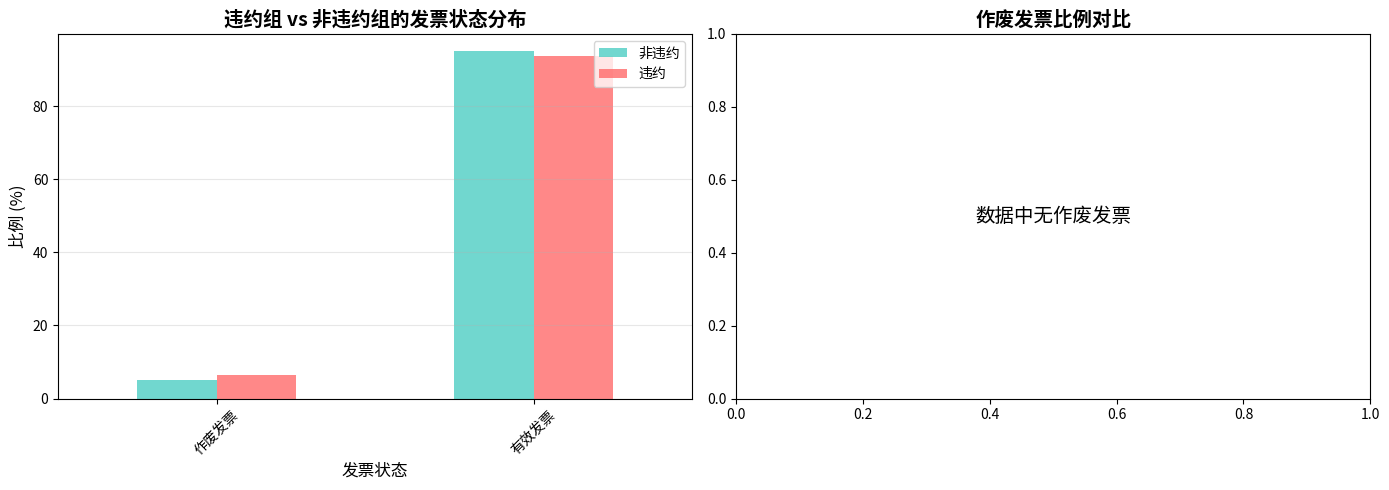


卡方检验: χ² = 48.18, p-value = 0.0000
✓ 发票状态与违约显著相关 (p < 0.05)


In [17]:
# ===========================================================
# 3.3. 发票层面的交易行为分析
# ===========================================================
print("\n--- 3.3. 发票层面的交易行为分析 ---")

# --- 3.3.1 发票状态 vs 是否违约 ---
print("\n【3.3.1 发票状态分析】")

# 计算违约组和非违约组的作废发票比例
status_by_default = df_combined.groupby(['是否违约', '发票状态']).size().unstack(fill_value=0)
status_pct = status_by_default.div(status_by_default.sum(axis=1), axis=0) * 100

print("\n违约组和非违约组的发票状态分布 (%):")
print(status_pct.round(2))

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 百分比堆积条形图
status_pct.T.plot(kind='bar', ax=axes[0], color=['#4ecdc4', '#ff6b6b'], alpha=0.8)
axes[0].set_title('违约组 vs 非违约组的发票状态分布', fontsize=14, fontweight='bold')
axes[0].set_xlabel('发票状态', fontsize=12)
axes[0].set_ylabel('比例 (%)', fontsize=12)
axes[0].legend(['非违约', '违约'], loc='upper right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# 作废发票比例对比 - 完全重写
if '作废' in status_pct.columns:
    # 创建新的DataFrame，索引改为中文标签
    void_comparison = pd.DataFrame({
        '作废发票比例': status_pct['作废']
    })
    void_comparison.index = ['非违约', '违约']  # 直接设置中文索引
    
    # 使用pandas绘图
    ax = void_comparison.plot(kind='bar', ax=axes[1], 
                               color=['#4ecdc4', '#ff6b6b'], 
                               alpha=0.8, legend=False)
    axes[1].set_title('作废发票比例对比', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('是否违约', fontsize=12)
    axes[1].set_ylabel('作废发票比例 (%)', fontsize=12)
    axes[1].set_xticklabels(['非违约', '违约'], rotation=0)
    axes[1].grid(axis='y', alpha=0.3)
    
    # 在柱子上显示具体数值
    for i, (idx, row) in enumerate(void_comparison.iterrows()):
        v = row['作废发票比例']
        axes[1].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)
else:
    axes[1].text(0.5, 0.5, '数据中无作废发票', ha='center', va='center', 
                 transform=axes[1].transAxes, fontsize=14)
    axes[1].set_title('作废发票比例对比', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 卡方检验
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(status_by_default)
print(f"\n卡方检验: χ² = {chi2:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("✓ 发票状态与违约显著相关 (p < 0.05)")
else:
    print("✗ 发票状态与违约无显著相关 (p >= 0.05)")


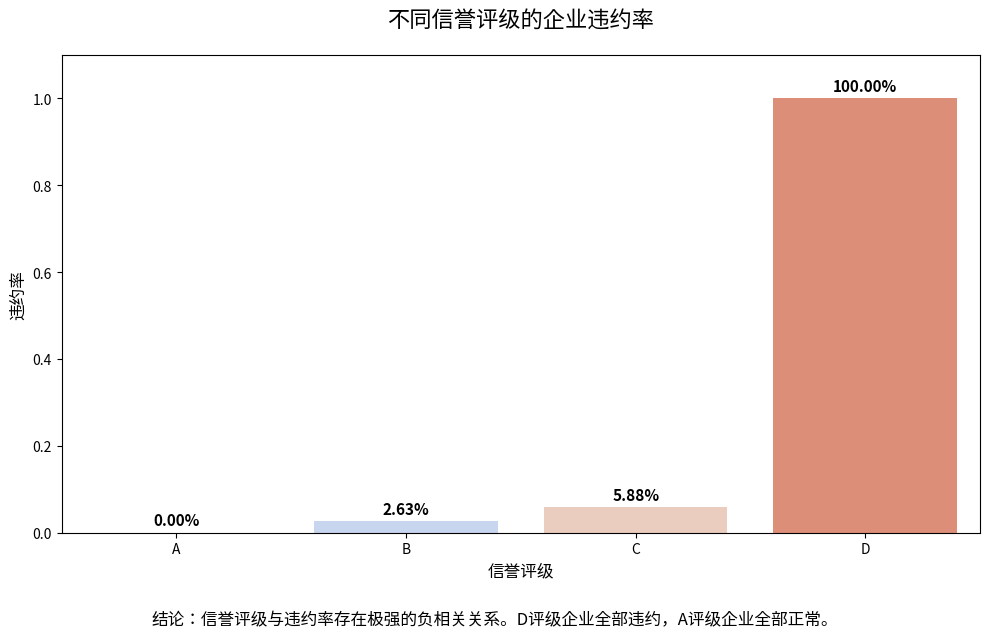

In [20]:
# --- 3.2. 企业静态属性分析 ---

# 步骤1: 计算需要可视化的数据
# SQL类比: 
# SELECT 信誉评级, AVG(CASE WHEN 是否违约='是' THEN 1 ELSE 0 END) AS 违约率
# FROM df_qiyexinxi GROUP BY 信誉评级;
rating_default_rate = df_qiyexinxi.groupby('信誉评级')['是否违约'].apply(
    lambda x: (x == '是').sum() / len(x)
).reset_index(name='违约率')

# 按照评级顺序排序
rating_order = ['A', 'B', 'C', 'D']
rating_default_rate['信誉评级'] = pd.Categorical(rating_default_rate['信誉评级'], categories=rating_order, ordered=True)
rating_default_rate = rating_default_rate.sort_values('信誉评级')

# 步骤2: 使用seaborn进行专业的可视化
plt.figure(figsize=(10, 6)) # 设置画布大小

# 使用条形图
ax = sns.barplot(data=rating_default_rate, x='信誉评级', y='违约率', palette='coolwarm')

# 步骤3: 添加细节，让图表“会说话”
plt.title('不同信誉评级的企业违约率', fontsize=16, pad=20)
plt.xlabel('信誉评级', fontsize=12)
plt.ylabel('违约率', fontsize=12)
plt.ylim(0, 1.1) # Y轴上限设为1.1，给顶部的标签留出空间

# 在每个条形图的顶部添加具体的百分比标签
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2%}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11,
                fontweight='bold')

# 添加结论性文字
plt.figtext(0.5, -0.05, 
            '结论：信誉评级与违约率存在极强的负相关关系。D评级企业全部违约，A评级企业全部正常。', 
            ha='center', fontsize=12, style='italic')
            
plt.tight_layout() # 自动调整布局
plt.show()